# 2.2.0 Running the CoxLab PredNet

The original PredNet wasn't straight forward to  get working. See [note-1.0](https://github.com/apra93/predictive-event-segmentation/blob/master/docs/source/notes/note-1.0-Running-the-CoxLab-PredNet.md) for details on getting their scripts running. This WB is for meesing with those scripts' innards.

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and other non-code related info
%watermark -n -m -g -b -t -h

Thu Aug 27 2020 15:12:55 

compiler   : GCC 7.5.0
system     : Linux
release    : 5.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
host name  : apra-x3
Git hash   : 4a276e8b21f39b812271fa7087ff1bd6d130e11d
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [101]:
# Set the matplotlib mode
%matplotlib inline

## Conda Env


In [4]:
!conda list

# packages in environment at /home/apra/miniconda3/envs/prednet:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       1_gnu    conda-forge
_tflow_select             2.1.0                       gpu    anaconda
absl-py                   0.9.0            py37hc8dfbb8_1    conda-forge
argon2-cffi               20.1.0                   pypi_0    pypi
astor                     0.8.1              pyh9f0ad1d_0    conda-forge
async-generator           1.10                     pypi_0    pypi
attrs                     20.1.0             pyh9f0ad1d_0    conda-forge
babel                     2.8.0                    pypi_0    pypi
backcall                  0.2.0                    pypi_0    pypi
beautifulsoup4            4.9.1                      py_1    conda-forge
bleach                    3.1.5                    pypi_0    pypi
brotlipy                  0.

## Imports

In [146]:
from pprint import pprint
import os
import numpy as np
from six.moves import cPickle
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
from keras import backend as K
from keras.preprocessing.image import Iterator
from keras.models import Model, model_from_json
from keras.layers import Input, Dense, Flatten
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from PIL import Image, ImageOps

%aimport prevseg.index
import prevseg.index as index
%aimport prevseg.schapiro
import prevseg.schapiro as sch

%aimport prednet.kitti_settings
import prednet.kitti_settings as ks
%aimport prednet.prednet_base
import prednet.prednet_base as pn
%aimport prednet.data_utils
import prednet.data_utils as utils

# Keep track of versions of everything
%watermark -v -iv

networkx   2.5
prevseg    0+untagged.52.g4a276e8.dirty
numpy      1.19.1
prednet    0+untagged.70.gc5532a0.dirty
matplotlib 3.3.1
PIL.Image  7.2.0
CPython 3.7.8
IPython 7.17.0


## Running the Evaluate Kitti Code

See `prednet.kitti_evaluate.py` for reference.

In [6]:
n_plot = 40
batch_size = 10
nt = 10
weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')
test_file = str(ks.DATA_DIR / 'X_test.hkl')
test_sources = str(ks.DATA_DIR / 'sources_test.hkl')

In [7]:
# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()
pprint(json_string)

('{"class_name": "Model", "keras_version": "2.0.6", "config": {"layers": '
 '[{"class_name": "InputLayer", "config": {"dtype": "float32", '
 '"batch_input_shape": [null, 10, 3, 128, 160], "name": "input_1", "sparse": '
 'false}, "inbound_nodes": [], "name": "input_1"}, {"class_name": "PredNet", '
 '"config": {"dtype": "float32", "trainable": true, "pixel_max": 1.0, '
 '"Ahat_filt_sizes": [3, 3, 3, 3], "return_state": false, "R_filt_sizes": [3, '
 '3, 3, 3], "unroll": false, "batch_input_shape": [null, null, null], '
 '"LSTM_inner_activation": "hard_sigmoid", "output_mode": "error", "stateful": '
 'false, "error_activation": "relu", "A_activation": "relu", "A_filt_sizes": '
 '[3, 3, 3], "stack_sizes": [3, 48, 96, 192], "name": "prednet_1", '
 '"R_stack_sizes": [3, 48, 96, 192], "data_format": "channels_first", '
 '"implementation": 0, "extrap_start_time": null, "go_backwards": false, '
 '"return_sequences": true, "LSTM_activation": "tanh"}, "inbound_nodes": '
 '[[["input_1", 0, 0, {}]]]

In [8]:
train_model = model_from_json(json_string, custom_objects = {'PredNet': pn.PredNet})
train_model.load_weights(weights_file)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [9]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config \
    else layer_config['dim_ordering']
test_prednet = pn.PredNet(weights=train_model.layers[1].get_weights(), 
                          **layer_config)

In [10]:
input_shape = list(train_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt
inputs = Input(shape=tuple(input_shape))
predictions = test_prednet(inputs)
test_model = Model(inputs=inputs, outputs=predictions)

In [11]:
print(test_file, test_sources, nt, data_format, sep='\n')

/home/apra/work/prednet/prednet/kitti_data/X_test.hkl
/home/apra/work/prednet/prednet/kitti_data/sources_test.hkl
10
channels_first


In [12]:
test_generator = utils.SequenceGenerator(test_file, 
                                         test_sources, 
                                         nt, 
                                         sequence_start_mode='unique', 
                                         data_format=data_format)
X_test = test_generator.create_all()

In [13]:
X_test.shape

(83, 10, 3, 128, 160)

In [14]:
X_hat = test_model.predict(X_test, batch_size)

In [15]:
# Presumably for plotting?
if data_format == 'channels_first':
    X_test = np.transpose(X_test, (0, 1, 3, 4, 2))
    X_hat = np.transpose(X_hat, (0, 1, 3, 4, 2))

In [16]:
print(X_test.shape, X_hat.shape, sep='\n')

(83, 10, 128, 160, 3)
(83, 10, 128, 160, 3)


In [17]:
mse_model = np.mean((X_test[:, 1:] - X_hat[:, 1:])**2)  # look at all timesteps except the first
mse_prev = np.mean((X_test[:, :-1] - X_test[:, 1:])**2)

In [18]:
print("Model MSE: %f" % mse_model)
print("Previous Frame MSE: %f" % mse_prev)

Model MSE: 0.006995
Previous Frame MSE: 0.021246


## Getting Model Representations

In [19]:
layer_config

{'name': 'prednet_1',
 'trainable': True,
 'batch_input_shape': (None, None, None),
 'dtype': 'float32',
 'return_sequences': True,
 'return_state': False,
 'go_backwards': False,
 'stateful': False,
 'unroll': False,
 'implementation': 0,
 'stack_sizes': [3, 48, 96, 192],
 'R_stack_sizes': [3, 48, 96, 192],
 'A_filt_sizes': [3, 3, 3],
 'Ahat_filt_sizes': [3, 3, 3, 3],
 'R_filt_sizes': [3, 3, 3, 3],
 'pixel_max': 1.0,
 'error_activation': 'relu',
 'A_activation': 'relu',
 'LSTM_activation': 'tanh',
 'LSTM_inner_activation': 'hard_sigmoid',
 'data_format': 'channels_first',
 'extrap_start_time': None,
 'output_mode': 'prediction'}

In [24]:
# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
X_Rs = []

test_generator = utils.SequenceGenerator(test_file, 
                                         test_sources, 
                                         nt, 
                                         sequence_start_mode='unique', 
                                         data_format=data_format)
X_test = test_generator.create_all()

for i in range(len(layer_config['R_stack_sizes'])):

    layer_config['output_mode'] = 'R' + str(i)
    data_format = layer_config['data_format'] if 'data_format' in layer_config \
        else layer_config['dim_ordering']
    test_prednet = pn.PredNet(weights=train_model.layers[1].get_weights(), 
                              **layer_config)

    input_shape = list(train_model.layers[0].batch_input_shape[1:])
    input_shape[0] = nt
    inputs = Input(shape=tuple(input_shape))
    R_outs = test_prednet(inputs)
    test_model = Model(inputs=inputs, outputs=R_outs)

    X_Rs.append(test_model.predict(X_test, batch_size))

In [25]:
X_Rs[-1].shape

(83, 10, 192, 16, 20)

## Matching the Schapiro Images to CoxLabs PredNet Input

In [30]:
X_test.shape

(83, 10, 3, 128, 160)

Each image needs to be of shape (3, 128, 160).

In [76]:
# Borrowing some code from ``prevseg/schapiro/resnet_embedding.py``

sch_shape = (128, 128)
pn_shape = (128, 160)

# Load and Resize
paths_fractals = list(index.DIR_SCH_FRACTALS.iterdir())
list_fractals = [Image.open(str(path)) for path in paths_fractals]
_ = [img.load() for img in list_fractals]

# Remove the alpha channel
list_fractals_no_alpha = [Image.new("RGB", pn_shape, (0,0,0))
                          for _ in range(len(list_fractals))]
_ = [bk.paste(img, (0, int((pn_shape[1]-sch_shape[1])/2 - 1)), mask=img.split()[3])
     for bk, img in zip(list_fractals_no_alpha, list_fractals)]

list_arrays = [np.moveaxis(np.array(img), (0,1,2), (2,1,0))
               for img in list_fractals_no_alpha]

In [80]:
# Save the embeddings
save_path = index.DIR_SCH / 'abstract_discs_resized_128_160/'
if not save_path.exists():
    save_path.mkdir()

for arr, path in zip(list_arrays, paths_fractals):
    # Turn to an array and reorder the dims
    np.save(str(save_path / path.stem), arr)
    arr2 = np.load(str(save_path / (path.stem + '.npy')))

    assert arr.shape == arr2.shape
    assert arr.mean() == arr2.mean()

This was made into the script `prevseg/schapiro/coxlab_resize.py`.

## Creating the Schapiro Datasets

### Finetuning Dataset

Using this paragraph fro "Results, Experiment 1" to create the dataset:

> Participants  viewed  a  35-min  sequence  of  individual  characters (Fig.1b), each presented for 1.5 s, in an order generated by a random walk on the graph in Figure 1a. During this phase, participants per-formed a cover task requiring them to decide whether each stimulus was  rotated  away  from  a  canonical  orientation  (Online  Methods). Task instructions avoided any allusion to the structure or relevance of the order of stimuli. In the next phase of the experiment, participants were shown another 15-min sequence and were asked to segment the stream by pressing the spacebar at times that felt like natural breaking points. This sequence alternated between blocks of 15 images gener-ated from a random walk on the graph and blocks of 15 images gener-ated from a randomly selected Hamiltonian path through the graph (a path visiting every node exactly once). The purpose of interspersing Hamiltonian paths was to ensure that parsing behavior could not be explained by local statistics of the sequence (for example, after seeing items within a cluster repeat several times, participants might use the relative novelty of an item from a new cluster as a parsing cue).


In [81]:
(35 * 60) / 1.5

1400.0

Start with 1400 total steps for training.

In [82]:
!pip install networkx

     |████████████████████████████████| 1.6 MB 1.5 MB/s eta 0:00:01


In [104]:
batch_size = 14
n_pentagons = 3
max_steps = 100
n_paths = 1
source = 1

paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
np.random.shuffle(paths_data)
paths_data = paths_data[:5*n_pentagons]
array_data = np.array([np.load(str(path)) for path in paths_data])

G = sch.graph.schapiro_graph(n_pentagons=n_pentagons)

mapping = {node : path.stem for node, path in zip(range(len(G.nodes)), paths_data)}

In [118]:
def iter_single_sample(G, mode, max_steps, source=None): 
    if mode == 'random':
        iter_walk = sch.walk.walk_random(G, steps=max_steps, source=source)
    elif mode == 'euclidean':
        iter_walk = sch.walk.walk_euclidean(G, source=source)
    elif mode == 'hamiltonian':
        iter_walk = sch.walk.walk_hamiltonian(G, source=source)
    else:
        raise ValueError('Invalid mode entered')

    for sample in iter_walk:
        yield array_data[sample[0]], sample[0]

def iter_batch_sample(G, mode, max_steps, batch_size, source=None):
    iter_batch = zip(*[iter_single_sample(G, mode, max_steps, source=source) 
                       for _ in range(batch_size)])
    for batch in iter_batch:
        data, nodes = zip(*batch)
        yield data, nodes

def iter_batch_dataset(G, mode, max_steps, batch_size, n_paths, source=None):       
    for _ in range(n_paths):
        data, nodes = zip(*list(iter_batch_sample(
            G, mode, max_steps, batch_size, source=source)))
        yield np.moveaxis(np.array(data), 0, 1), nodes

fine_tune_data_iter = iter_batch_dataset(G, 'random', max_steps, batch_size, n_paths)
fine_tune_data, fine_tune_nodes = next(fine_tune_data_iter)
fine_tune_data.shape

(14, 100, 3, 128, 160)

### Reference Schapiro Graph

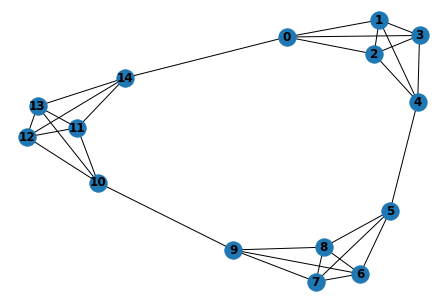

In [112]:
nx.draw(G, with_labels=True, font_weight='bold')
plt.show()

### Testing Dataset

In [127]:
euclidean_iter = iter_batch_dataset(G, 'euclidean', None, 1, n_paths, source=source)
_, euclidean_nodes = next(euclidean_iter)

In [128]:
euclidean_nodes = list(np.array(euclidean_nodes).reshape(30))
euclidean_nodes

[1,
 4,
 3,
 2,
 4,
 5,
 8,
 9,
 7,
 8,
 6,
 7,
 5,
 6,
 9,
 10,
 13,
 14,
 12,
 13,
 11,
 12,
 10,
 11,
 14,
 0,
 3,
 1,
 2,
 0]

In [132]:
# Inlcude some non-important steps the start to allow the hidden state to adapt
initial_padding = [1,0,1,0,1,0]
test_walk_nodes = initial_padding + euclidean_nodes

test_data = np.expand_dims(np.array([array_data[n] for n in test_walk_nodes]),0)
test_data.shape

(1, 36, 3, 128, 160)

### Using Sequence Generators

In [168]:
class ShapiroFractalsDataset(Iterator):
    modes = set(('random', 'euclidean', 'hamiltonian'))
    def __init__(self, batch_size=32, n_pentagons=3, max_steps=128, n_paths=128,
                 mapping=None, mode='random', debug=False, seed=None, shuffle=False):
        self.batch_size = batch_size
        self.n_pentagons = n_pentagons
        self.max_steps = max_steps
        self.n_paths = n_paths
        self.mapping = mapping
        self.mode = mode
        self.debug = debug
        assert self.mode in self.modes
        
        self.G = graph.schapiro_graph(n_pentagons=n_pentagons)
        
        self.load_node_stimuli()
        
        self.mapping = {node : path.stem
                        for node, path in zip(range(len(self.G.nodes)),
                                              self.paths_data)}
        print(f'Created mapping as follows:\n{self.mapping}')
        
        if self.debug:
            self.sample_transform = lambda sample : sample
        else:
            self.sample_transform = lambda sample : self.array_data[sample]
        super().__init__(self.n_paths, self.batch_size, shuffle, seed)
        
    def load_node_stimuli(self):
        # Load the fractal images into memory
        assert index.DIR_SCH_FRACTALS_RS.exists()
        if self.mapping:
            self.paths_data = [index.DIR_SCH_FRACTALS_RS / (name+'.npy')
                               for name in self.mapping.values()]
        else:
            paths_data = list(index.DIR_SCH_FRACTALS_RS.iterdir())
            np.random.shuffle(paths_data)
            self.paths_data = paths_data[:5*self.n_pentagons]
        self.array_data = np.array([np.load(str(path)) for path in self.paths_data])
        
    def iter_single_sample(self): 
        if self.mode == 'random':
            iter_walk = sch.walk.walk_random(self.G, steps=self.max_steps)
        elif self.mode == 'euclidean':
            iter_walk = sch.walk.walk_euclidean(self.G)
        elif self.mode == 'hamiltonian':
            iter_walk = sch.walk.walk_hamiltonian(self.G)

        for sample in iter_walk:
            yield self.array_data[sample[0]], sample[0]
        
    def iter_batch_sample(self):
        iter_batch = zip(*[self.iter_single_sample()
                           for _ in range(self.batch_size)])
        for batch in iter_batch:
            data, nodes = zip(*batch)
            yield data, nodes
        
    def iter_batch_dataset(self):   
        for _ in range(self.n_paths):
            data, nodes = zip(*list(self.iter_batch_sample()))
            yield np.moveaxis(np.array(data), 0, 1), nodes
        
    def __iter__(self):
        return self.iter_batch_dataset()
    
    def __getitem__(self, null):
        data_iter = self.iter_batch_dataset()
        data = next(data_iter)[0]
        data2 = np.zeros(data.shape)
        data2[:,:-1,:,:,:] = data[:,1:,:,:,:]
        return data, data2
    
max_steps = 100
epochs = 1
batch_size = 14
n_paths = 1

iter_ds = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                 mapping=mapping)
for _ in range(epochs):
    for i, batch in enumerate(iter_ds):
        print(i, batch[0].shape)
        if i > max_steps+5:
            print('bad')
            break

Created mapping as follows:
{0: '20', 1: '90', 2: '51', 3: '25', 4: '17', 5: '56', 6: '85', 7: '45', 8: '89', 9: '48', 10: '3', 11: '100', 12: '30', 13: '15', 14: '33'}
0 (14, 100, 3, 128, 160)


## Fine Tuning on the Fractals

In [162]:
nt = fine_tune_data.shape[1]
extrap_start_time = 10  # starting at this time step, the prediction from the previous time step will be treated as the actual input
orig_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')  # original t+1 weights
orig_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')

fractals_weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights-fractals_finetuned.hdf5')  # where new weights will be saved
fractals_json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model-fractals_finetuned.json')

In [ ]:
save_model = False
nb_epoch = 150
batch_size = 14
samples_per_epoch = None
N_seq_val = 50  # number of sequences to use for validation

# Load t+1 model
f = open(orig_json_file, 'r')
json_string = f.read()
f.close()
orig_model = model_from_json(json_string, custom_objects = {'PredNet': pn.PredNet})
orig_model.load_weights(orig_weights_file)

layer_config = orig_model.layers[1].get_config()
layer_config['output_mode'] = 'prediction'
data_format = layer_config['data_format'] if 'data_format' in layer_config else layer_config['dim_ordering']
prednet = pn.PredNet(weights=orig_model.layers[1].get_weights(), **layer_config)

input_shape = list(orig_model.layers[0].batch_input_shape[1:])
input_shape[0] = nt

inputs = Input(input_shape)
predictions = prednet(inputs)
model = Model(inputs=inputs, outputs=predictions)
model.compile(loss='mean_absolute_error', optimizer='adam')

train_generator = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                    mapping=mapping)
val_generator = ShapiroFractalsDataset(batch_size=batch_size, max_steps=max_steps, n_paths=n_paths,
                                  mapping=mapping)
                                  
lr_schedule = lambda epoch: 0.001 if epoch < 75 else 0.0001    # start with lr of 0.001 and then drop to 0.0001 after 75 epochs
callbacks = [LearningRateScheduler(lr_schedule)]
if save_model:
    if not os.path.exists(WEIGHTS_DIR): os.mkdir(WEIGHTS_DIR)
    callbacks.append(ModelCheckpoint(filepath=extrap_weights_file, monitor='val_loss', save_best_only=True))
history = model.fit_generator(train_generator, samples_per_epoch, nb_epoch, callbacks=callbacks,
                validation_data=None)

if save_model:
    json_string = model.to_json()
    with open(extrap_json_file, "w") as f:
        f.write(json_string)

Created mapping as follows:
{0: '20', 1: '90', 2: '51', 3: '25', 4: '17', 5: '56', 6: '85', 7: '45', 8: '89', 9: '48', 10: '3', 11: '100', 12: '30', 13: '15', 14: '33'}
Created mapping as follows:
{0: '20', 1: '90', 2: '51', 3: '25', 4: '17', 5: '56', 6: '85', 7: '45', 8: '89', 9: '48', 10: '3', 11: '100', 12: '30', 13: '15', 14: '33'}
Epoch 1/150


## Test Running CLPN on the Fractals

In [134]:
batch_size = 1
nt = test_data.shape[1]
weights_file = str(ks.WEIGHTS_DIR / 'tensorflow_weights/prednet_kitti_weights.hdf5')
json_file = str(ks.WEIGHTS_DIR / 'prednet_kitti_model.json')
test_file = str(ks.DATA_DIR / 'X_test.hkl')
test_sources = str(ks.DATA_DIR / 'sources_test.hkl')

# Load trained model
f = open(json_file, 'r')
json_string = f.read()
f.close()

train_model = model_from_json(json_string, custom_objects = {'PredNet': pn.PredNet})
train_model.load_weights(weights_file)

# Create testing model (to output predictions)
layer_config = train_model.layers[1].get_config()
X_Rs = []

for i in range(len(layer_config['R_stack_sizes'])):

    layer_config['output_mode'] = 'R' + str(i)
    data_format = layer_config['data_format'] if 'data_format' in layer_config \
        else layer_config['dim_ordering']
    test_prednet = pn.PredNet(weights=train_model.layers[1].get_weights(), 
                              **layer_config)

    input_shape = list(train_model.layers[0].batch_input_shape[1:])
    input_shape[0] = nt
    inputs = Input(shape=tuple(input_shape))
    R_outs = test_prednet(inputs)
    test_model = Model(inputs=inputs, outputs=R_outs)

    X_Rs.append(test_model.predict(test_data, batch_size))